In [1]:
from os import walk
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = "./Dados_StoAndre"
start_date = "16/12/2019"
header_names = ["hour", "kwh_h", "ch1", "ch2", "ch3", "ch4", "ch5", "ch6", "ch7", "ch8", "ch9", "ch10", "tem_h", "avgT", "minT", "maxT"]
files = []

for (_, _, filenames) in walk(data_dir):
    files.extend(filenames)
    break

time_series = pd.date_range(start=start_date, periods=24*len(files) - 13, freq='H')

hist_data = pd.DataFrame()
for i in range(len(files)):
    file = files[i]
    df = pd.read_csv(data_dir + '/' + file, header=None, names=header_names, delim_whitespace=True)
    hist_data = pd.concat([hist_data, df])

hist_data = hist_data.set_index(time_series)

<Figure size 432x288 with 0 Axes>

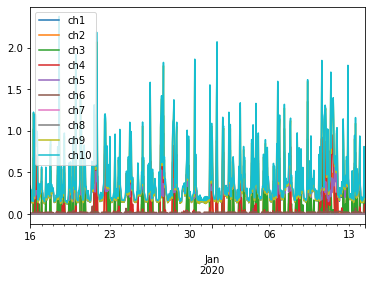

In [3]:
plt.figure()
hist_data.loc[:, 'ch1':'ch10'].plot()

<Figure size 432x288 with 0 Axes>

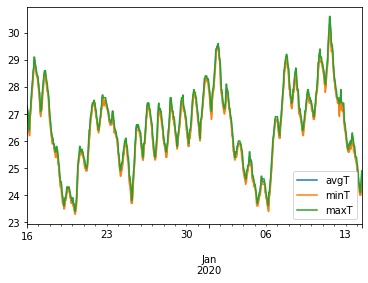

In [4]:
plt.figure()
hist_data.loc[:, 'avgT':'maxT'].plot()

In [5]:
for i in range(1, 11):
    print(hist_data['ch' + str(i)].corr(hist_data['avgT']))

0.2710461866997085
0.2229577018599883
0.0073211287468068825
0.3401706315753091
0.21072149814087163
0.2334987271411489
0.12388903033791117
0.17544496881530164
0.2555682524475588
0.26069201386270047


<Figure size 432x288 with 0 Axes>

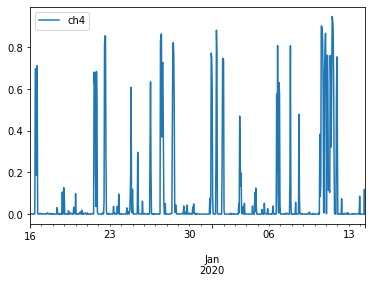

In [6]:
plt.figure()
hist_data.loc[:, ['ch4']].plot()

<Figure size 432x288 with 0 Axes>

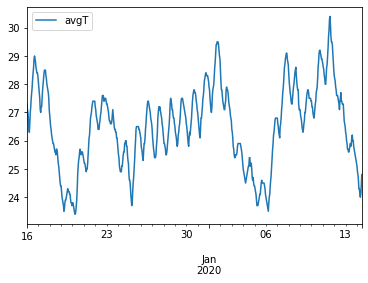

In [7]:
plt.figure()
hist_data.loc[:, ['avgT']].plot()